In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import RobertaTokenizer, RobertaModel, AdamW
from torch.optim import AdamW
import matplotlib.pyplot as plt
from itertools import product
import torch.nn.functional as F

/Users/maxschaffelder/venv/first_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load data
df = pd.read_csv("Data/persuasion_data.csv")

In [4]:
# Define the model architecture
class RobertaRegression(torch.nn.Module):
    def __init__(self, base_model):
        super(RobertaRegression, self).__init__()
        self.base_model = base_model
        self.regressor = torch.nn.Linear(base_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0, :]  # CLS token
        return self.regressor(pooled_output)

# Set the device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

# Load the tokenizer and base model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
base_model = RobertaModel.from_pretrained('roberta-base')

# Initialize the regression model
model = RobertaRegression(base_model)
model = model.to(device)

# Load the saved model state
model.load_state_dict(torch.load('/Users/maxschaffelder/Desktop/Social Computing/Term Project/Code/soc_project/Models/roberta_regressor.pth', map_location=device))
model.eval()
print("Model loaded successfully")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully


In [5]:
# Prediction function

def predict_scores(model, tokenizer, texts, max_len=512, device='mps'):
    model.to(device)
    model.eval()
    predictions = []

    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            prediction = output.squeeze().item()
            predictions.append(prediction)
    
    return predictions


In [6]:
# Make prediction for entire dataset and add in new column

arguments = df['argument'].tolist()

# Predict scores
predicted_scores = predict_scores(model, tokenizer, arguments, device="mps")

# Add the predicted scores to the DataFrame
df['predicted_score'] = predicted_scores

# Save the updated DataFrame (optional)
# df.to_csv('Data/persuasion_data_with_argqual.csv', index=False)

# Print the DataFrame to verify the new column
df.head()

,worker_id,claim,argument,source,prompt_type,rating_initial,rating_final,persuasiveness_metric,predicted_score
0,PQVTZECGNK3K,Governments and technology companies must do m...,It's time for governments and tech companies t...,Claude 2,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0,1.910730
1,3KTT9HNPV9WX,Governments and technology companies must do m...,"In today's hyper-connected world, our personal...",Claude 3 Haiku,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0,1.820516
2,M76GMRF46C69,Cultured/lab-grown meats should be allowed to ...,The future of food must include cultured/lab-g...,Claude 2,Compelling Case,3 - Somewhat oppose,5 - Somewhat support,2,1.939637
3,3W4KKCTPTP7R,Social media companies should be required to l...,Social media companies should be required to l...,Claude 2,Compelling Case,3 - Somewhat oppose,6 - Support,3,2.011710
4,QQDKMRY3HRXJ,Employers should be allowed to monitor employe...,Allowing employers to monitor employees throug...,Claude 3 Opus,Logical Reasoning,5 - Somewhat support,5 - Somewhat support,0,1.909627


In [8]:
#df.to_csv("Data/persuasion_data_preds.csv")

In [ ]:
# Predictions for our annotated data

df_annotated = pd.read_csv("Data/arguments_to_annotate.csv")
arguments = df_annotated['argument'].tolist()

# Predict scores
predicted_scores = predict_scores(model, tokenizer, arguments, device="mps")

# Add the predicted scores to the DataFrame
df_annotated['predicted_score'] = predicted_scores

# Save the updated DataFrame (optional)
# df_annotated.to_csv('Data/arguments_to_annotate_with_argqual.csv', index=False)

# Print the DataFrame to verify the new column
#df_annotated.head()

<Axes: >

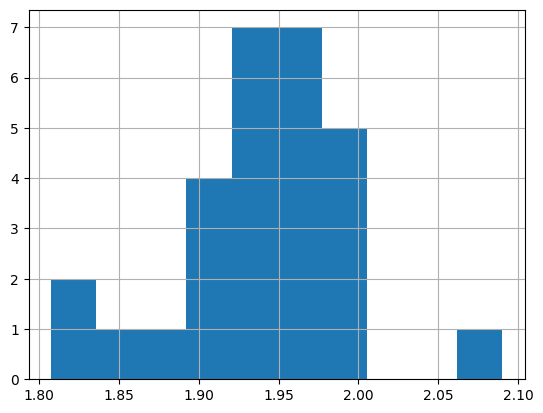

In [18]:
df_annotated["predicted_score"].hist()